In [2]:
# import sys
# !{sys.executable} -m pip install ing_theme_matplotlib
# import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import qbstyles
from ing_theme_matplotlib import mpl_style
# import glacierml as gl
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Step 1: Organize the data

## A. Load and organize the Glathida dataset

In [4]:
list(TT)

['GlaThiDa_ID',
 'POLITICAL_UNIT',
 'GLACIER_NAME',
 'SURVEY_DATE',
 'LOWER_BOUND',
 'UPPER_BOUND',
 'AREA',
 'MEAN_SLOPE',
 'MEAN_THICKNESS',
 'MEAN_THICKNESS_UNCERTAINTY',
 'MAXIMUM_THICKNESS',
 'MAX_THICKNESS_UNCERTAINTY',
 'DATA_FLAG',
 'REMARKS']

In [5]:
# raw_dataset = pd.read_csv('/data/fast0/datasets/glathida-3.1.0/data/T.csv')
TT = pd.read_csv('/home/sa42/data/glac/T_models/TT.csv')
TT = TT[[
    'LOWER_BOUND',
    'UPPER_BOUND',
    'AREA',
    'MEAN_SLOPE',
    'MEAN_THICKNESS',
    'MAXIMUM_THICKNESS',
]]
glathida = TT
glathida = glathida.dropna()

### separate out features - what will be trained to predict desired attribute

In [6]:
train_dataset = glathida.sample(frac=0.8, random_state=0)
test_dataset = glathida.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MAXIMUM_THICKNESS")
test_labels = test_features.pop("MAXIMUM_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LOWER_BOUND,3205.591270,825.956760
UPPER_BOUND,3254.769841,841.514265
AREA,0.173664,0.356148
MEAN_SLOPE,24.015873,11.599206
MEAN_THICKNESS,22.091270,21.467747


# Step 2: Setup the Model

### Establish normalization layers

In [7]:
normalizer = {}
variable_list = list(train_features)
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

2022-03-18 15:35:56.735195: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-18 15:35:56.735276: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-18 15:35:56.735964: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Single variable linear regression functions

In [8]:
# glacierml

def build_linear_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss='mean_absolute_error')
    
    return model

def plot_single_model_variable(x, y,feature_name):
    plt.scatter(train_features[feature_name], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature_name)
    plt.ylabel('Avg Thickness (m)')
#     plt.xlim((0,20))
    plt.legend()
      
def plot_loss(history):
#     plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [9]:
test_results = {}
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [10]:
%%time
for variable_name in variable_list:

    linear_model[variable_name] = build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

CPU times: user 3min 8s, sys: 1min 41s, total: 4min 49s
Wall time: 2min 50s


{'LOWER_BOUND': 33.85676956176758,
 'UPPER_BOUND': 33.8268928527832,
 'AREA': 38.548316955566406,
 'MEAN_SLOPE': 36.59646224975586,
 'MEAN_THICKNESS': 9.257368087768555}

In [11]:
for variable_name in variable_list:    
    df = pd.DataFrame(linear_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print('')


        Variable       loss   val_loss
999  LOWER_BOUND  25.899817  24.828503

        Variable       loss  val_loss
999  UPPER_BOUND  25.730524  25.10309

    Variable       loss   val_loss
999     AREA  32.345127  23.570328

       Variable       loss  val_loss
999  MEAN_SLOPE  29.526308  25.12887

           Variable      loss   val_loss
999  MEAN_THICKNESS  8.304336  10.858731



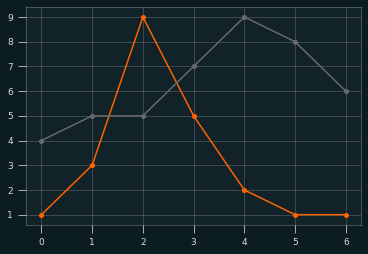

In [12]:
import matplotlib.pyplot as plt
from ing_theme_matplotlib import mpl_style
 
def plot(dark):
  mpl_style(dark)
  plt.plot([1, 3, 9, 5, 2, 1, 1], marker='o')
  plt.plot([4, 5, 5, 7, 9, 8, 6], marker='o')
 
  plt.show()
 
plot(dark=True)

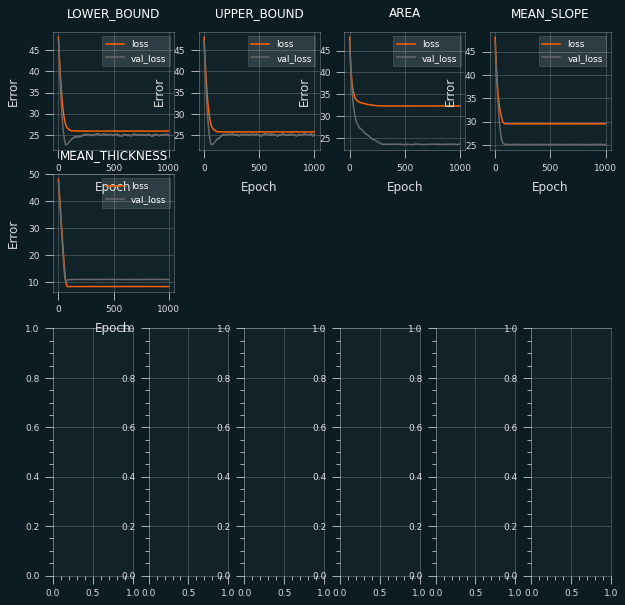

In [13]:
fig,ax=plt.subplots(2,6,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    mpl_style("dark")
    ax = plt.subplot(4,4,i+1)
    plt.subplot(4,4,i+1)
    plot_loss(linear_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_loss.eps")

# Linear regression with multiple inputs

In [14]:
linear_model = build_linear_model(normalizer['ALL'])

history_full = linear_model.fit(
train_features, train_labels,        
   epochs=1000,
   verbose=0,
   validation_split = 0.2)

test_results['MULTI'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'MULTI': 8.46084213256836}

In [15]:
df = pd.DataFrame(history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)



           Variable      loss   val_loss
999  Multi-Variable  7.960654  10.743738


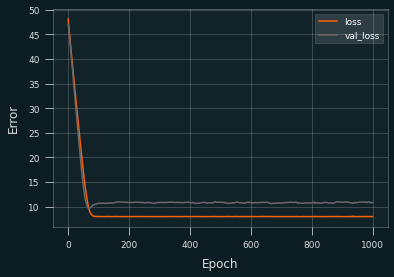

In [16]:
plot_loss(history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

## Define regression functions

In [17]:
def build_dnn_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
    
    return model

def dnn_test_results(feature_name):
    dnn_test_results[feature_name] = dnn_model.evaluate(
        test_features[feature_name],
        test_labels, verbose=0)

In [18]:
test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [19]:
for variable_name in variable_list:

    dnn_model[variable_name] = build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

{'LOWER_BOUND': 31.294925689697266,
 'UPPER_BOUND': 32.35851287841797,
 'AREA': 30.38004493713379,
 'MEAN_SLOPE': 35.46577453613281,
 'MEAN_THICKNESS': 8.756269454956055}

In [20]:
for variable_name in variable_list:    
    df = pd.DataFrame(dnn_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print('')


        Variable       loss   val_loss
999  LOWER_BOUND  24.752216  22.792877

        Variable       loss   val_loss
999  UPPER_BOUND  24.707972  23.709604

    Variable       loss   val_loss
999     AREA  22.205357  23.564926

       Variable       loss   val_loss
999  MEAN_SLOPE  26.802647  27.627504

           Variable      loss   val_loss
999  MEAN_THICKNESS  8.320765  10.525203



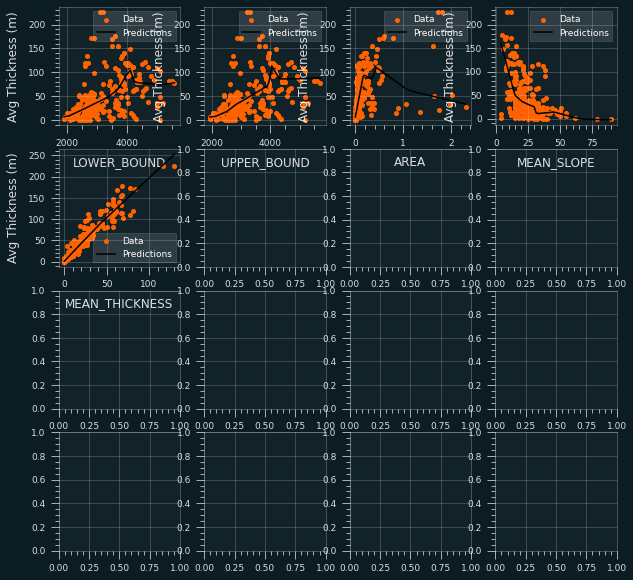

In [21]:
fig,ax=plt.subplots(4,4,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(4,4,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = dnn_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

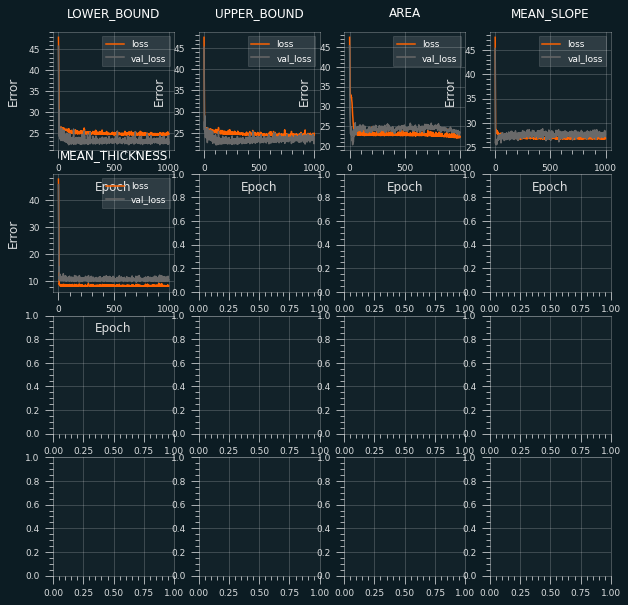

In [22]:
fig,ax=plt.subplots(4,4,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(4,4,i+1)
    plot_loss(dnn_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")

# Full model

In [23]:
dnn_full_model = build_dnn_model(normalizer['ALL'])

In [24]:
%%time
dnn_history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: user 1min 20s, sys: 33.6 s, total: 1min 53s
Wall time: 32.1 s


In [25]:
df = pd.DataFrame(dnn_history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)


           Variable      loss  val_loss
999  Multi-Variable  3.177881  8.002883


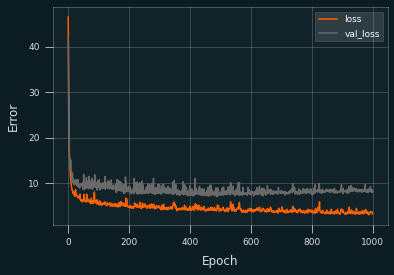

In [26]:
plot_loss(dnn_history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

(0.0, 200.0)

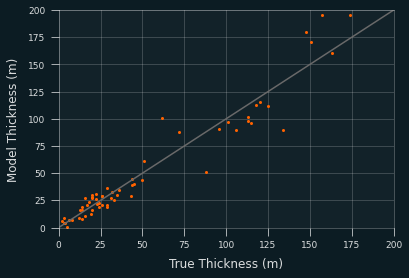

In [27]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,200),(0,200),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,200))
plt.ylim((0,200))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")